<h1><center>BAG of Word</center></h1>

In [2]:
## Only run this if you are using Google Colab and need to install new packages 
# via the notebook before you can use them
!pip3 install powerlaw
!pip3 install pyLDAvis

/bin/sh: pip3: not found
/bin/sh: pip3: not found


In [5]:


#import common libraries:
#------------------------
import pandas as pd #<- For managing the datasets
import re #<- For accessing a folder path
import numpy as np #<- For doing mathematical operation with arrays.
import matplotlib.pyplot as plt #<- To plot in python

#New libraries from the Natural Lenguage Toolkit (Human language data):
#----------------------------------------------------------------------
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #<- For finding tokens (small divisions) from a large sample of text
from nltk.corpus import stopwords #<- For calling the know stopwords in english (e.g, articles, connectors)
from nltk.corpus import wordnet #<- For calling a lexical database in eglish with meanings, synonyms, antonyms, and more 
from nltk.stem import WordNetLemmatizer #<- For normalizing the words in a text, for example, different conjugations of a verb and its brings its simple form.

#New libraries from the sklearn the library for machine learning in python:
#--------------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #<- To vectorize our text into terms frequencies
from sklearn.decomposition import LatentDirichletAllocation #<- To classify our text into groups based on the vectors of frequencies

#New libraries for topic modelling:
#---------------------------------
import gensim #<- Topic modelling library 
import gensim.corpora as corpora #<- To create a corpus of our text
from pprint import pprint

#New libraries for visualizing the topics in a topic model from a corpus (gensim):
#---------------------------------------------------------------------------------
import pyLDAvis #<- Visualization library
import pyLDAvis.gensim #<- Connecting with gensim
from wordcloud import WordCloud



# Import library for managing collections/
import collections

# Import library for fitting powerlaw functions to data
import powerlaw


#Extra libraries:
%matplotlib inline
import warnings
# Suppress warnings for aesthetic purposes
warnings.filterwarnings("ignore", category=DeprecationWarning)  

ModuleNotFoundError: No module named 'pandas'

## 1. Implementing the Bag of Words Algorithm

In [6]:
def vectorize(tokens):
    ''' This function takes list of words in a sentence as input 
    and returns a vector of size of filtered_vocab.It puts 0 if the 
    word is not present in tokens and count of token if present.'''
    vector=[]
    for w in filtered_vocab:
        vector.append(tokens.count(w))
    return vector


def unique(sequence):
    '''This functions returns a list in which the order remains 
    same and no item repeats.Using the set() function does not 
    preserve the original ordering,so i didnt use that instead'''
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

# Import a list of stopwords from NLTK
stops = stopwords.words('english')

# Create a list of special characters which go between words
special_char=[",",":"," ",";",".","?"]

#Write the sentences in the corpus,in our case, just two 
string1="Welcome to Great Learning , Now start learning"
string2="Learning is a good practice"

#convert them to lower case
string1=string1.lower()
string2=string2.lower()
#split the sentences into tokens
tokens1=string1.split()
tokens2=string2.split()
print(tokens1)
print(tokens2)
#create a vocabulary list
vocab=unique(tokens1+tokens2)
print(vocab)
#filter the vocabulary list
filtered_vocab=[]
for w in vocab: 
    if w not in stops and w not in special_char: 
        filtered_vocab.append(w)
print(filtered_vocab)
#convert sentences into vectords
vector1=vectorize(tokens1)
print(vector1)
vector2=vectorize(tokens2)
print(vector2)

['welcome', 'to', 'great', 'learning', ',', 'now', 'start', 'learning']
['learning', 'is', 'a', 'good', 'practice']
['welcome', 'to', 'great', 'learning', ',', 'now', 'start', 'is', 'a', 'good', 'practice']
['welcome', 'great', 'learning', 'start', 'good', 'practice']
[1, 1, 2, 1, 0, 0]
[0, 0, 1, 0, 1, 1]


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
sentence_1="This is a good job. I will not miss it for anything"
sentence_2="This is not a good job at all"
 
 
 
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')
#Transform to vectors
Count_data = CountVec.fit_transform([sentence_1,sentence_2])
 
#Create dataframe from Vectors
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(cv_dataframe)

   good  job  miss
0     1    1     1
1     1    1     0


In [8]:
#2 Grams
CountVec = CountVectorizer(ngram_range=(2, 2), 
                           stop_words='english')
#Transform to vectors
Count_data = CountVec.fit_transform([sentence_1,sentence_2])
 
#Create dataframe from Vectors
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(cv_dataframe)

   good job  job miss
0         1         1
1         1         0


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
# Cosine similarity with 1 grams
cosine_similarity(np.asarray([vector1, vector2]))

array([[1.        , 0.43643578],
       [0.43643578, 1.        ]])

In [10]:
# Cosine similarity with 2-grams
cosine_similarity(cv_dataframe)

array([[1.        , 0.70710678],
       [0.70710678, 1.        ]])

In [11]:
from scipy.spatial.distance import euclidean
# Euclidean distance with 1-grams
euclidean(vector1, vector2)

2.449489742783178

In [12]:
# Euclidean distance with 2-grams
euclidean(cv_dataframe.loc[0], cv_dataframe.loc[1])

1.0

## 2. TF-IDF and Comparing Documents

In [16]:
# Load the two text files into memory 
text1 = open("Text1.txt").read()
text2 = open("Text2.txt").read()

In [17]:
# Print them in two separate paragraphs for a quick overview
print("Text 1:\n", text1)
print("\n Text 2:\n", text2)

Text 1:
 When Hillary Clinton wanted to speak about women’s rights at the 1995 United Nations Fourth World Conference on Women in Beijing, even her own side was dubious. ‘People were saying: “This is a not an important issue for the US government, it’s a nice thing and I’m glad you care about it, but if the First Lady of the United States goes and actually speaks about women’s rights, that elevates an issue that in the midst of everything else going on – the collapse of the USSR and the transition of the former Soviet states and Warsaw Pact nations and Rwanda and Bosnia, there was so much else going on in the world – maybe you should speak about it from afar.”’ As we will see (and as the US administration already knew at the time) what was ‘going on’ in Rwanda and Bosnia was the mass and systematic rape of women. When things go wrong – war, natural disaster, pandemic – all the usual data gaps we have seen everywhere from urban planning to medical care are magnified and multiplied. But 

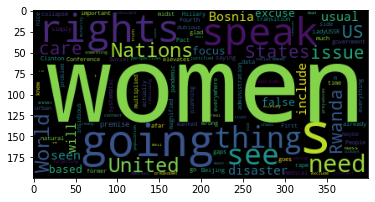

In [18]:
# Now - lets use the wordcloud package to create some visualisation overviews
plt.imshow(WordCloud().generate(text1))

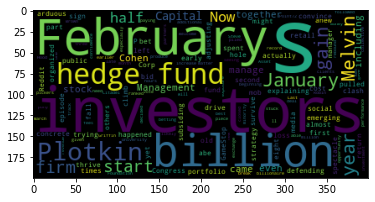

In [19]:
plt.imshow(WordCloud().generate(text2))

When comparing these two word clouds - what do you notice?

Now, we will explore different ways to use tf-idf to analyse and compare documents

Lets see what the frequency distribution of words in these documents looks like. 

In [23]:

def zipf_law_plot(Ordered_Frequency, Absolute_frequency):
  n = 20
  Rank = [i for i in range(n)]
  x = Rank
  y = list(Absolute_frequency.values())[:n]

  ax = plt.subplot(111) #<-- define the plot to allow annotation
  ax.loglog(x,y,'go-', alpha=0.2) #<-- plot in the log log form
  Strings = list(Ordered_Frequency.keys()) #<-- Set the top 20 most frequent words

  #The annotations start position in 1 then we sum 1 or do a range(1,20)
  for i in range(19):
      ax.annotate(Strings[i], xy=(x[i+1], y[i+1]), fontsize=12)
      
  plt.xlabel('Frequency rank of words', fontsize = 'x-large')
  plt.ylabel('Absolut frequency of words', fontsize = 'x-large')
  plt.show()
  

In [24]:
def words_frequency_rank(text):

  words = re.findall(r'\w+', text) #<-- Select the element of the text that are words
  Counting_words = dict(collections.Counter(words)) #<-- Count the words

  #Order the counting: lambda is another way to write functions: https://www.w3schools.com/python/python_lambda.asp
  Ordered_frequency = {k: v for k, v in sorted(Counting_words.items(), key=lambda item: item[1], reverse = True)}

  #Calculate the absolute frequency:
  Absolute_frequency = {k:Ordered_frequency[k]/np.sum(list(Ordered_frequency.values())) for k in Ordered_frequency.keys()}
  return Ordered_frequency, Absolute_frequency


In [25]:
Ordererd_Frequency_1, Absolute_Frequency_1 = words_frequency_rank(text1)
Ordererd_Frequency_2, Absolute_Frequency_2 = words_frequency_rank(text2)

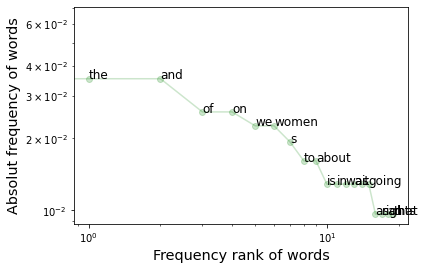

In [26]:
zipf_law_plot(Ordererd_Frequency_1, Absolute_Frequency_1)

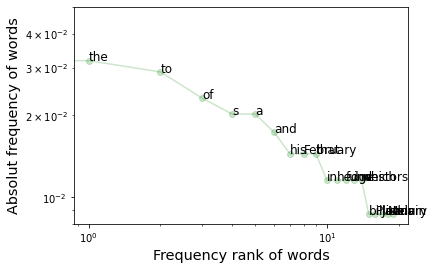

In [27]:
zipf_law_plot(Ordererd_Frequency_2, Absolute_Frequency_2)

In [28]:
def Plot_pdf_CCDF(Data, xlabel, ylabel):

    
    '''This function plot and compares the the Probability Density Function (PDF) and the Complement Cummulative
    Density Function. This functions are taken from the paper: https://doi.org/10.1371/journal.pone.0085777
    
    Attributes:
    Data: An array of values
    '''
    
    fit = powerlaw.Fit(Data) #<-- Fit the data
    fig2=fit.plot_pdf(color='b', linewidth=2) #<-- Plot the PDF of the original data

    fit.power_law.plot_pdf(color='b', linestyle='dashed', ax=fig2) #<-- Plot the PDF of the power law fit

    fit.plot_ccdf(color='r', linewidth=2, ax=fig2) #<-- Plot the PDF of the original data in the same fig

    fit.power_law.plot_ccdf(color='r', linestyle='dashed', ax=fig2) #<-- Plot the PDF of the power law fit

    plt.legend(['Data pdf', 'fit PDF', 'Data CCDF', 'fit CCDF'], fontsize = 'x-large')
    plt.xlabel(xlabel, fontsize = 'x-large')
    plt.ylabel(ylabel, fontsize = 'x-large')
    plt.show()

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/site-packages/powerlaw-1.4.4-py3.7.egg/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/powerlaw-1.4.4-py3.7.egg/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide


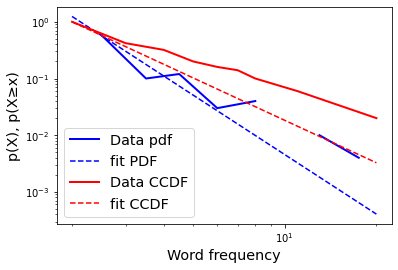

In [29]:
Plot_pdf_CCDF(list(Ordererd_Frequency_1.values()), 'Word frequency', 'p(X), p(X≥x)')

Calculating best minimal value for power law fit
/usr/local/lib/python3.7/site-packages/powerlaw-1.4.4-py3.7.egg/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/powerlaw-1.4.4-py3.7.egg/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide


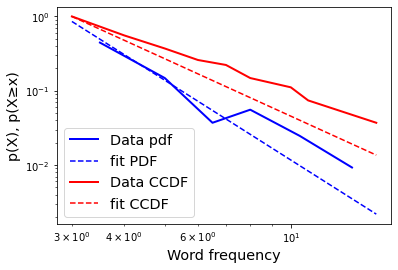

In [30]:
Plot_pdf_CCDF(list(Ordererd_Frequency_2.values()), 'Word frequency', 'p(X), p(X≥x)')

Now, lets look at the vectoriser again and see how we can more directly compare two documents

In [31]:
# TF-IDF Document Comparison
texts = [text1, text2]
vectorizer = TfidfVectorizer(stop_words=stops)

In [32]:
transformed_texts = vectorizer.fit_transform(texts)
transformed_text_array = transformed_texts.toarray()


In [33]:
tf_idf_dataframes = []
for counter, txt in enumerate(transformed_text_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), txt))
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])


In [34]:
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = ["Text 1", "Text 2"]
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']


In [35]:
tf_idf_doc_comparison.head(20)

,Text 1,Text 2
Tf-IDF Ranking,,
0,women,investors
1,going,february
2,rights,fund
3,see,billion
4,usual,hedge
5,disaster,firm
6,include,january
7,care,melvin
8,issue,plotkin


In [36]:
# Now lets see how strongly the two documents correlate with one another
correlation_matrix = ((transformed_texts * transformed_texts.T).A)

In [37]:
# It appears these two documents are very different to one another once stop words have been removed
correlation_matrix

array([[1.        , 0.01550176],
       [0.01550176, 1.        ]])

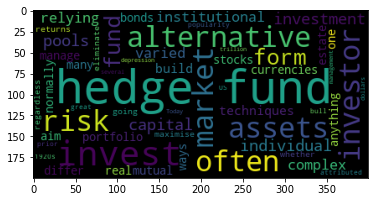

In [38]:
# Lets try adding another text, and see which it matches more closely
text3 = open("Text3.txt").read()
# Text 3 is a document explaining the definition of a hedge fund, so it should be 
# More closely related to text 2 than text 1. 
plt.imshow(WordCloud().generate(text3))

In [39]:
texts = [text1, text2, text3]

In [40]:
transformed_texts = vectorizer.fit_transform(texts)
transformed_text_array = transformed_texts.toarray()


In [41]:
tf_idf_dataframes = []
for counter, txt in enumerate(transformed_text_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), txt))
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])


In [42]:
tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = ["Text 1", "Text 2", "Text 3"]
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']


In [43]:
tf_idf_doc_comparison.head(20)

,Text 1,Text 2,Text 3
Tf-IDF Ranking,,,
0,women,february,hedge
1,going,billion,funds
2,see,investors,invest
3,rights,hedge,alternative
4,states,fund,often
5,bosnia,firm,risk
6,things,plotkin,assets
7,care,melvin,individual
8,include,gain,techniques


In [44]:
correlation_matrix = ((transformed_texts * transformed_texts.T).A)
correlation_matrix

array([[1.        , 0.01886375, 0.02372792],
       [0.01886375, 1.        , 0.15384558],
       [0.02372792, 0.15384558, 1.        ]])

Text(0.5, 1.0, 'Text Similarity')

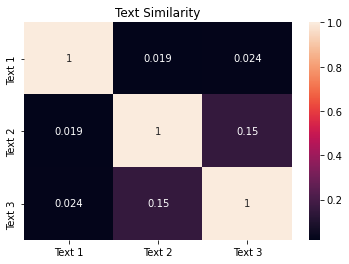

In [45]:
import seaborn as sns
labels = ["Text 1", "Text 2", "Text 3"]
sns.heatmap(correlation_matrix, annot=True, xticklabels= labels, yticklabels= labels)
plt.title("Text Similarity")

In [46]:
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(2,2))


transformed_texts = vectorizer.fit_transform(texts)
transformed_text_array = transformed_texts.toarray()

tf_idf_dataframes = []
for counter, txt in enumerate(transformed_text_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), txt))
    tf_idf_dataframes.append(pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)['term'])


tf_idf_doc_comparison = pd.DataFrame(tf_idf_dataframes).T
tf_idf_doc_comparison.columns = ["Text 1", "Text 2", "Text 3"]
tf_idf_doc_comparison.index.names = ['Tf-IDF Ranking']

tf_idf_doc_comparison.head(20)


,Text 1,Text 2,Text 3
Tf-IDF Ranking,,,
0,include women,hedge fund,hedge funds
1,rwanda bosnia,10 billion,maximise investor
2,need focus,investors organized,investor returns
3,based false,investors survive,invest stocks
4,false premise,january clash,invest varied
5,else going,january defending,bull markets
6,women rights,january investment,build portfolio
7,excuse need,last month,today hedge
8,side dubious,late january,often relying


<AxesSubplot:>

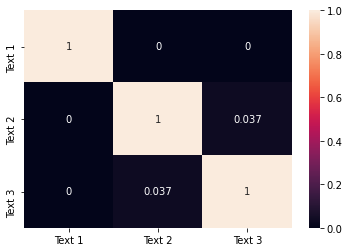

In [47]:
correlation_matrix = ((transformed_texts * transformed_texts.T).A)
correlation_matrix


labels = ["Text 1", "Text 2", "Text 3"]
sns.heatmap(correlation_matrix, annot=True, xticklabels= labels, yticklabels= labels)

In [48]:
## BONUS
# Add topic labels
labels = ["Hillary Clinton", "Hedge Funds"]
# Remove the second hedge funds article to prevent training class imbalance
texts = [text1, text2]

# Import feature extraction functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Fit and transform vectorisers for the two documents
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(texts) 

tf_transformer = TfidfTransformer(use_idf=True).fit(x_train_counts)

x_train_tf = tf_transformer.transform(x_train_counts)

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Create a classifier and fit it to the training data 
clf = MultinomialNB().fit(x_train_tf, labels)
clf_kn = KNeighborsClassifier(n_neighbors = 1).fit(x_train_tf, labels)

In [50]:
# Add some new strings (from wikipedia) to match to the two topics
new_strings = ["Hillary Diane Rodham Clinton (born October 26, 1947) is an American politician, diplomat, lawyer, writer, and public speaker who served as the 67th United States secretary of state from 2009 to 2013, as a United States senator from New York from 2001 to 2009, and as First Lady of the United States from 1993 to 2001", 
               "Although hedge funds are not subject to many restrictions that apply to regulated funds, regulations were passed in the United States and Europe following the financial crisis of 2007–2008 with the intention of increasing government oversight of hedge funds and eliminating certain regulatory gaps."]


# Transform the new strings to vectors
x_test_counts = count_vect.transform(new_strings)
x_test_tfidf = tf_transformer.transform(x_test_counts)

# Predict class using the classifier
clf.predict(x_test_tfidf)

array(['Hillary Clinton', 'Hedge Funds'], dtype='<U15')

In [51]:
clf_kn.predict(x_test_tfidf)

array(['Hillary Clinton', 'Hedge Funds'], dtype='<U15')